In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
import string

%matplotlib inline

sys.path.append('../src/')
from preprocess import preprocess_text
from optimal_clusters import identify_topics


from tqdm import tqdm
from collections import Counter
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [2]:
df = pd.read_excel('../Data/st-data-full.xlsx')
df.head()

,text,label
0,"if you were curious, price chose the lowest ch...",1
1,"true, not even 10k followers here yet.",1
2,dogecoin co-founder billy markus hits back at ...,1
3,"i’m curious, do any bulls have a price where ...",1
4,friday everybody buy 10 more on friday,2


In [3]:
df.shape

(600000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    599975 non-null  object
 1   label   600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ MB


In [5]:
df.isna().sum()

text     25
label     0
dtype: int64

In [6]:
# drop missing values
df.dropna(inplace=True)

In [7]:
df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
df.shape

(599975, 2)

In [9]:
df.loc[30000, "text"]

' back over .3 today'

In [10]:
df.loc[30000, "label"]

2

In [11]:
df.loc[150000, "text"]

' robinhood and dogecoin are giving away dogecoin, bitcoin and e... '

In [12]:
df.loc[150000, "label"]

1

In [13]:
df.loc[400, "text"]

' if your not worried your a fucking liar'

In [14]:
df.loc[400, "label"]

1

### Label

In [15]:
df['label'].value_counts()

2    305079
1    239043
0     55853
Name: label, dtype: int64

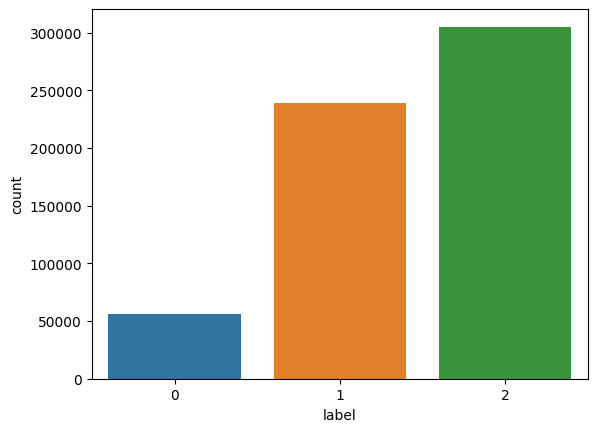

In [16]:
sns.countplot(x='label', data=df);

In [17]:
df['label'] = df['label'].replace({0: "Bearish", 1: "Neutral", 2: "Bullish"})
df['label'].value_counts()

Bullish    305079
Neutral    239043
Bearish     55853
Name: label, dtype: int64

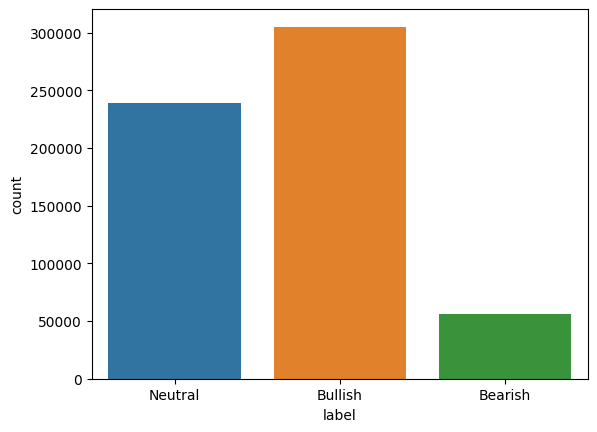

In [18]:
sns.countplot(x='label', data=df);

## Text Pre-processing

In [19]:
df = preprocess_text(df)

100%|██████████████████████████████| 599975/599975 [00:00<00:00, 3462021.35it/s]


In [20]:
df.head()

,text,label,tokens,Clean_text
0,"if you were curious, price chose the lowest ch...",Neutral,"[curious, price, chose, lowest, chamber, good,...",curious price chose lowest chamber good imo
1,"true, not even 10k followers here yet.",Neutral,"[true, even, 10k, follower, yet]",true even 10k follower yet
2,dogecoin co-founder billy markus hits back at ...,Neutral,"[dogecoin, cofounder, billy, markus, hit, back...",dogecoin cofounder billy markus hit back mozil...
3,"i’m curious, do any bulls have a price where ...",Neutral,"[curious, bull, price, pull, either, positive,...",curious bull price pull either positive negati...
4,friday everybody buy 10 more on friday,Bullish,"[friday, everybody, buy, 10, friday]",friday everybody buy 10 friday


In [21]:
df['tokens'][150000]

['robinhood', 'dogecoin', 'giving', 'away', 'dogecoin', 'bitcoin', 'e']

In [22]:
df['text'][150000]

' robinhood and dogecoin are giving away dogecoin, bitcoin and e... '

In [23]:
df['Clean_text'][150000]

'robinhood dogecoin giving away dogecoin bitcoin e'

In [24]:
df['text'][2]

"dogecoin co-founder billy markus hits back at mozilla's decision to halt crypto donations, calls internet outrage 'hypocritical and stupid'"

In [25]:
df['tokens'][2]

['dogecoin',
 'cofounder',
 'billy',
 'markus',
 'hit',
 'back',
 'mozillas',
 'decision',
 'halt',
 'crypto',
 'donation',
 'call',
 'internet',
 'outrage',
 'hypocritical',
 'stupid']

In [26]:
df['Clean_text'][2]

'dogecoin cofounder billy markus hit back mozillas decision halt crypto donation call internet outrage hypocritical stupid'

## Word-count distribution

In [27]:
tokens = df['tokens']

In [28]:
counter = []
for t in tokens:
    for word in t:
        counter.append(word)

len(counter)

4766455

In [29]:
# Obtaining The Total Number Of Unique Words
unique_words = len(list(set(counter)))
unique_words

85512

In [30]:
counts = Counter(counter)
counts.most_common(10)

[('buy', 41958),
 ('crypto', 37415),
 ('go', 37112),
 ('get', 37062),
 ('like', 34427),
 ('bitcoin', 32645),
 ('going', 31813),
 ('time', 30601),
 ('bear', 26788),
 ('back', 25527)]

## Vectorization

In [31]:
vect = CountVectorizer(min_df=0.001, max_df=0.8)

X = vect.fit_transform(df['Clean_text'])

1. The `min_df=600` parameter sets the minimum document frequency for the CountVectorizer. This means that only terms that appear in at least `600` documents will be included in the vocabulary. Terms that appear in fewer than `600` documents will be ignored.
2. `max_df`: Specifies the maximum document frequency that a word can have to be considered for vectorization. This parameter can be useful to filter out words that are too common and may not be informative. The default value is 1.0, which means that words that appear in all documents will be removed.
3. `ngram_range`: Specifies the range of `n-grams` to consider for vectorization. An n-gram is a contiguous sequence of n words. For example, if `ngram_range=(1,2)`, the vectorizer will consider both individual words and pairs of consecutive words (bigrams). This parameter can be useful to capture not only individual words but also the context in which they appear. The default value is (1,1), which means that only individual words will be considered.

In [32]:
# Check the shape of X
print("Shape of X:", X.shape)

# Check the sparsity of X
sparsity = 1.0 - (X.count_nonzero() / float(X.shape[0] * X.shape[1]))
print("Sparsity of X:", sparsity)

Shape of X: (599975, 1207)
Sparsity of X: 0.9954261405465217


1. The `shape of X` indicates that there are `599,975` documents (i.e., tweets) and `1,207` unique words in the vocabulary after filtering by `min_df` and `max_df`.

2. The `sparsity of X` is quite high, at `0.9954`, which means that over `99.5%` of the entries in the matrix are `zero`. This is not unexpected, given that the number of `unique` words is much smaller than the number of documents, and many of the words that do appear are likely to be rare.

In [33]:
# Define the CountVectorizer object with updated parameters
vect = CountVectorizer(min_df=0.0005, max_df=0.5, ngram_range=(1, 2), max_features=5000)

# Apply the vectorizer to the clean text data
X1 = vect.fit_transform(df['Clean_text'])

# Print the shape and sparsity of the resulting matrix
print("Shape of X:", X1.shape)
print("Sparsity of X:", 1 - X1.nnz / float(X1.shape[0] * X1.shape[1]))

Shape of X: (599975, 2400)
Sparsity of X: 0.9972948324235732


It looks like reducing the `min_df` and `max_df` values and adding additional parameters has resulted in a higher number of features in the vocabulary (`2400` instead of `1207`), but also a slightly higher sparsity (`0.9973` instead of `0.9954`). In general, it's a trade-off between capturing more information versus reducing noise and computational complexity.

In [34]:
vect = CountVectorizer(min_df=600, max_df=0.8, ngram_range=(1, 2))

# Apply the vectorizer to the clean text data
X2 = vect.fit_transform(df['Clean_text'])

# Print the shape and sparsity of the resulting matrix
print("Shape of X:", X2.shape)
print("Sparsity of X:", 1 - X2.nnz / float(X2.shape[0] * X2.shape[1]))

Shape of X: (599975, 1316)
Sparsity of X: 0.9956410569791978


It looks like by setting `min_df=600`, we have drastically reduced the size of the vocabulary (`1342` instead of `2483`) and increased the sparsity of the matrix (`0.9958` instead of `0.9974`). Additionally, by setting `ngram_range=(1, 2)`, we have included bigrams as well as unigrams in the vectorization process. This may capture more information about phrases and collocations in the text data. 

In [35]:
# lET'S TRY SOMETHING ELSE

# Create an instance of the vectorizer with desired parameters
vectorizer = TfidfVectorizer(min_df=1000)

# Apply the vectorizer to the clean text data
X3 = vectorizer.fit_transform(df['Clean_text'])

# Print the shape and sparsity of the resulting matrix
print("Shape of X:", X3.shape)
print("Sparsity of X:", 1 - X3.nnz / float(X3.shape[0] * X3.shape[1]))

Shape of X: (599975, 812)
Sparsity of X: 0.9938242746978169


In [36]:
# lET'S TRY SOMETHING ELSE

# Create an instance of the vectorizer with desired parameters
vectorizer = TfidfVectorizer(min_df=50,max_features=10000)

# Apply the vectorizer to the clean text data
X4 = vectorizer.fit_transform(df['Clean_text'])

# Print the shape and sparsity of the resulting matrix
print("Shape of X:", X4.shape)
print("Sparsity of X:", 1 - X4.nnz / float(X4.shape[0] * X4.shape[1]))

Shape of X: (599975, 6056)
Sparsity of X: 0.9988578203638273


## Clustering

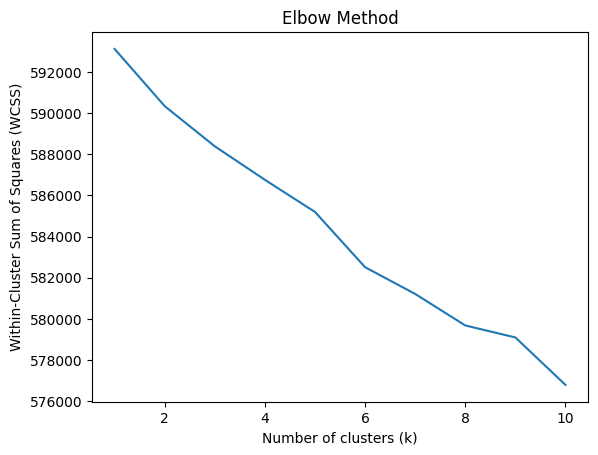

In [37]:
# Define a range of k values to test
k_values = range(1, 11)

# Compute the WCSS for each value of k
wcss_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X4)
    wcss_values.append(kmeans.inertia_)

# Plot the WCSS as a function of k
plt.plot(k_values, wcss_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

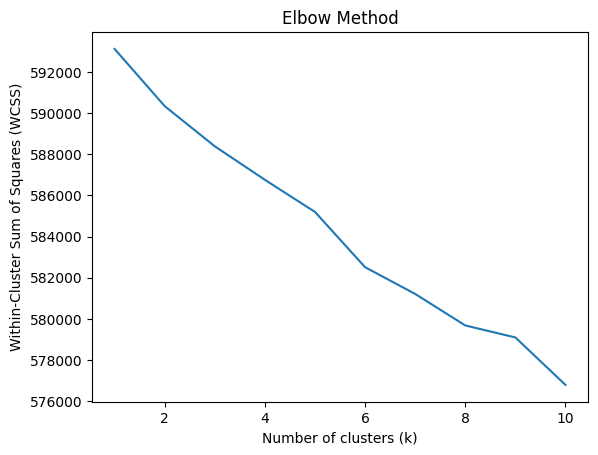

In [38]:
# Define a range of k values to test
k_values = range(1, 11)

# Compute the WCSS for each value of k
wcss_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X4)
    wcss_values.append(kmeans.inertia_)

# Plot the WCSS as a function of k
plt.plot(k_values, wcss_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

### Finding the optimal k

0    544259
1     29192
2     26524
Name: Cluster, dtype: int64


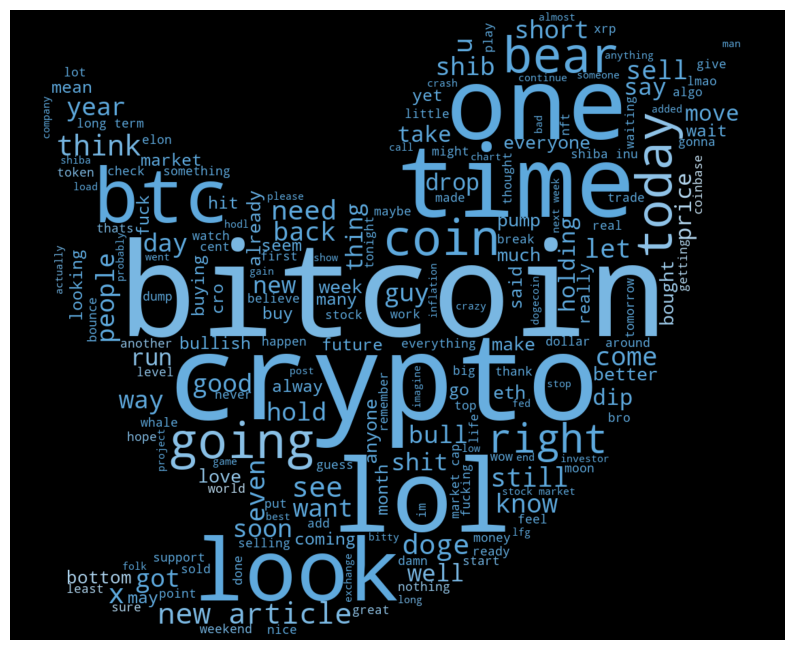

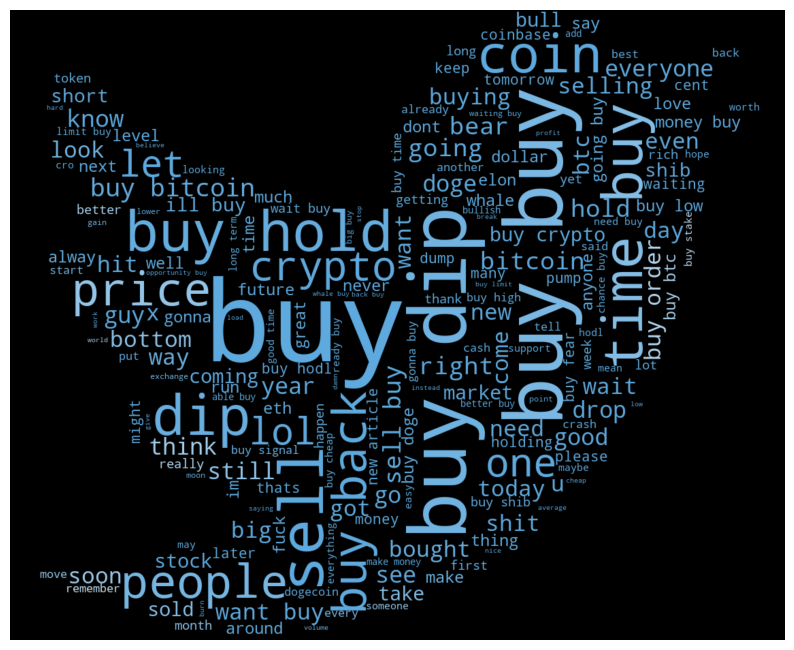

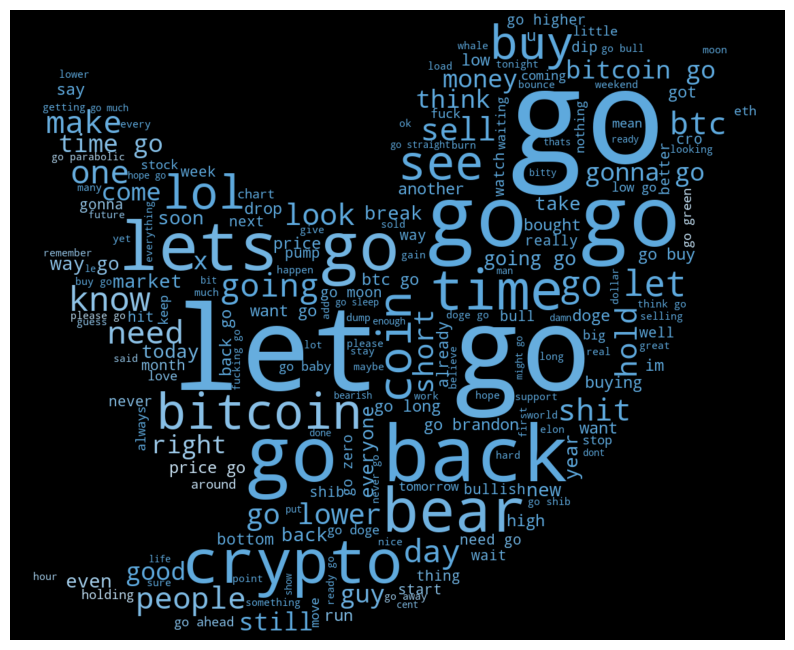

In [39]:
identify_topics(df, X4, 3)

0    484292
2     26536
1     26038
3     24184
5     23523
4     15402
Name: Cluster, dtype: int64


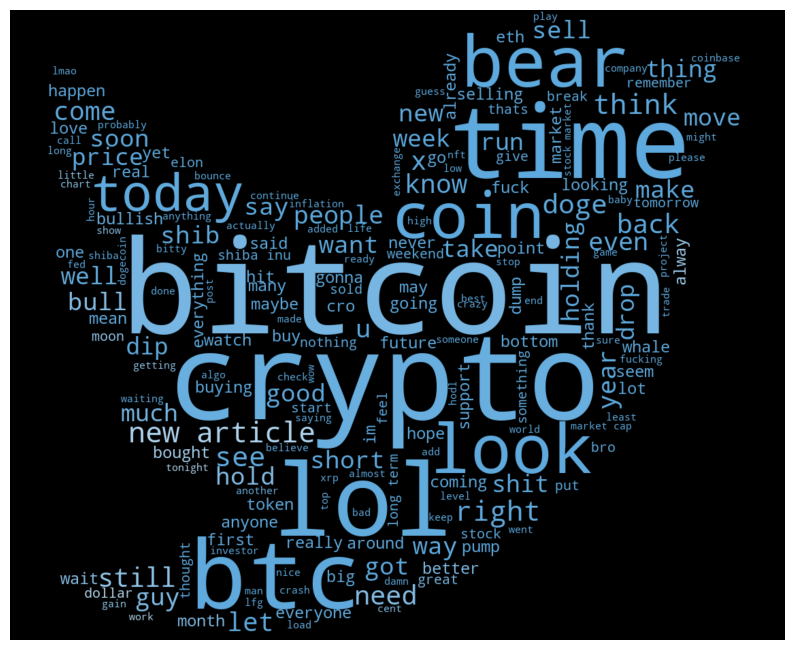

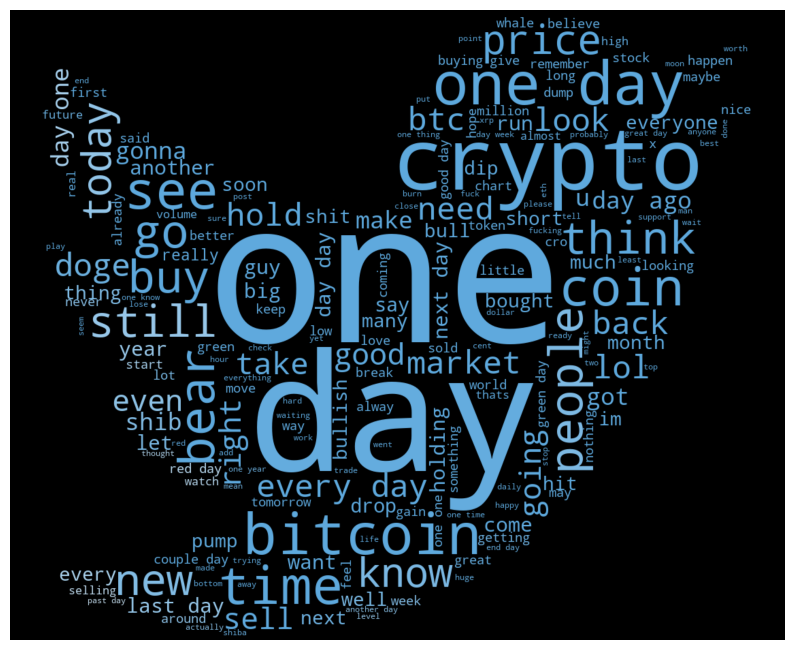

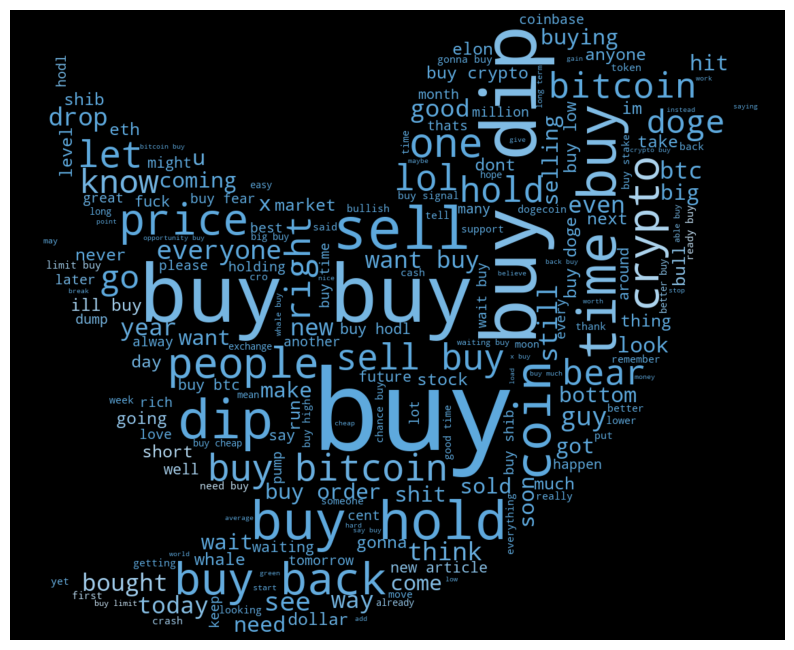

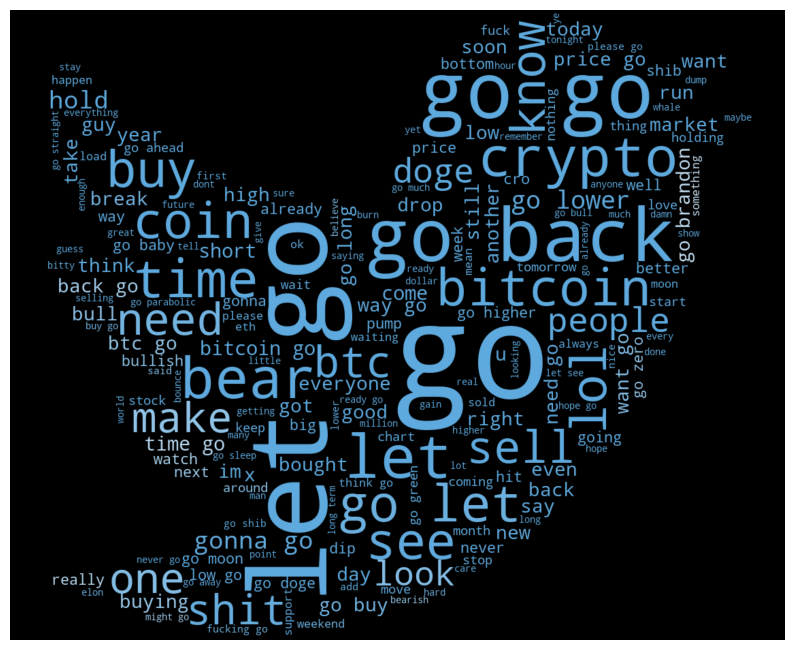

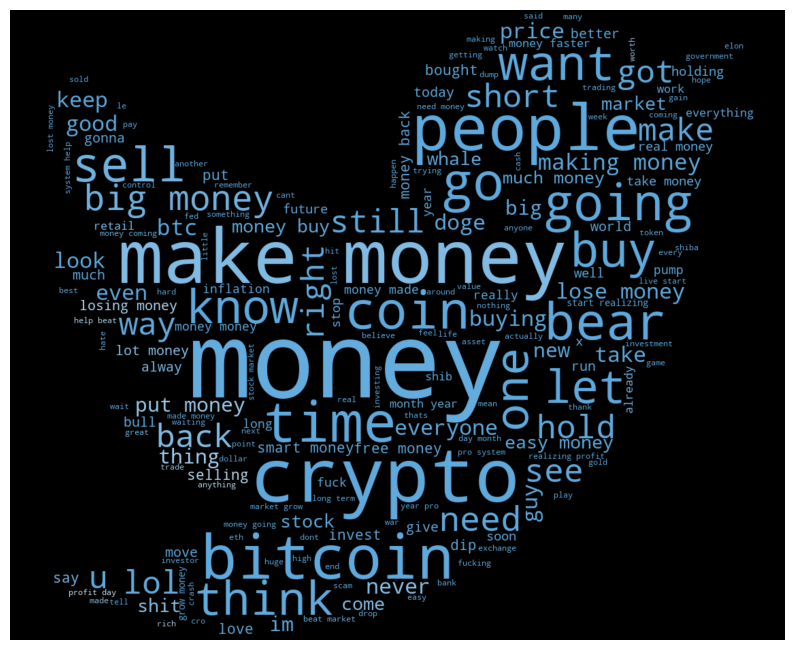

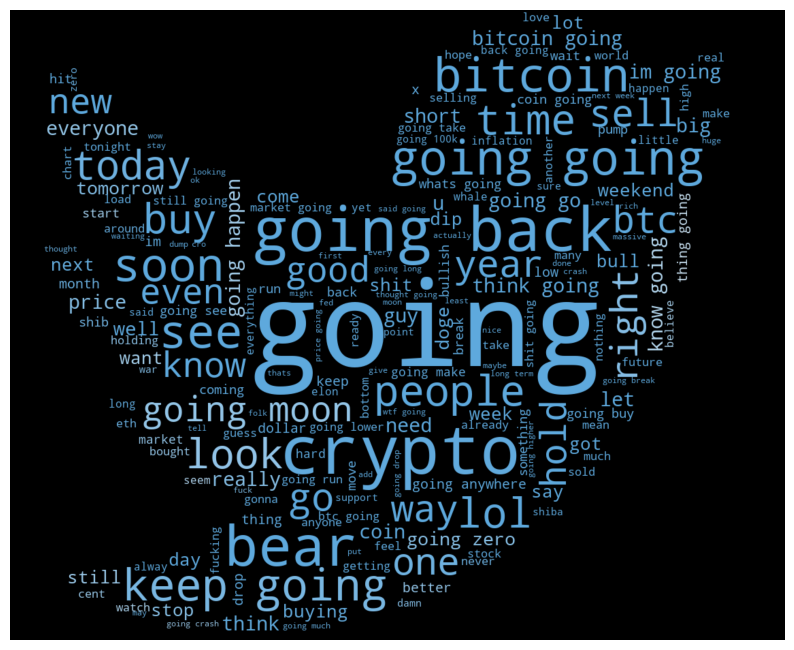

In [41]:
identify_topics(df, X4, 6)

-------